In [118]:
from datetime import datetime, timedelta
import numpy as np

import cartopy as cp
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.ticker as mticker
import matplotlib.patheffects as peffects

from spacepy import coordinates as coord

In [2]:
from classes import Riometer, HyperSpectralRiometer, IrisRiometer, LaJollaRiometer
from utils import load_object

In [3]:
riometer_list = load_object("Riometer_List")

In [4]:
la_jolla_riometers = [rio for rio in riometer_list if rio.riometer_type == "La Jolla"]

riometers = {}

for rio in la_jolla_riometers:
    riometers[rio.name] = rio

print("{" + "\n \n".join("{!r}: {!r},".format(k, v) for k, v in riometers.items()) + "}")

{'Dawson, YK': LaJollaRiometer(name='Dawson, YK', tag='daws', lon=-139.43, lat=64.05, status='Currently Operating', riometer_type='La Jolla'),
 
'Churchill, MB': LaJollaRiometer(name='Churchill, MB', tag='chur', lon=-94.08, lat=58.76, status='Currently Operating', riometer_type='La Jolla'),
 
'Fort Smith, NWT': LaJollaRiometer(name='Fort Smith, NWT', tag='fsmi', lon=-111.88, lat=60, status='Currently Operating', riometer_type='La Jolla'),
 
'Pinwa, MB': LaJollaRiometer(name='Pinwa, MB', tag='pina', lon=-95.88, lat=50.15, status='Currently Operating', riometer_type='La Jolla'),
 
'Rankin Inlet, NU': LaJollaRiometer(name='Rankin Inlet, NU', tag='rank', lon=-92.085, lat=62.81, status='Currently Operating', riometer_type='La Jolla'),
 
'Taloyoak, NU': LaJollaRiometer(name='Taloyoak, NU', tag='talo', lon=-93.53, lat=69.54, status='Currently Operating', riometer_type='La Jolla'),
 
'Fort Simpson, NWT': LaJollaRiometer(name='Fort Simpson, NWT', tag='fsim', lon=-121.35, lat=61.86, status='Curr

In [222]:
class OrthoMap:
    
    def __init__(self, central_riometer, radius, r_padding, title, 
                        width = 900, height = 900, dpi = 200, resolution = '50m',
                        lon_shift =0, lat_shift=0) -> None:
        
        self.central_lon, self.central_lat = central_riometer.lon, central_riometer.lat
        
        self.radius    = radius
        self.r_padding = r_padding
        
        self.width      = width
        self.height     = height
        self.dpi        = dpi
        self.resolution = resolution
        
        self.lon_shift = lon_shift
        self.lat_shift = lat_shift

        self.title = title

        self.__post_init__()
        
    def __post_init__(self):
        
        self.ortho = cp.crs.Orthographic(central_longitude=self.central_lon + self.lon_shift, central_latitude=self.central_lat + self.lat_shift)
        self.pad_radius = self.compute_radius(self.radius + self.r_padding)
        
    
    
    def compute_radius(self, radius_degrees):

        theta1 = self.central_lon + radius_degrees if self.central_lon <= 0 else self.central_lon - radius_degrees
        phi    = self.central_lat + radius_degrees if self.central_lat <= 0 else self.central_lat - radius_degrees

        x, y = self.ortho.transform_point(self.central_lon, phi, cp.crs.PlateCarree())

        return np.sqrt( (x)**2 + (y)**2 )

    def plot_features(self, ax):
        
        ax.imshow(np.tile(np.array([[cp.feature.COLORS['water'] * 255]], dtype=np.uint8), [2, 2, 1]), origin='upper', transform=cp.crs.PlateCarree(), 
                                                                        extent=[-180, 180, -180, 180], alpha=0.9)
        ax.add_feature(cp.feature.NaturalEarthFeature('physical', 'land', self.resolution, edgecolor='black', facecolor=cp.feature.COLORS['land']), alpha=0.7)
        ax.add_feature(cp.feature.NaturalEarthFeature('cultural', 'admin_0_countries', self.resolution, edgecolor='black', facecolor='none', alpha=0.3 ))
        ax.add_feature(cp.feature.NaturalEarthFeature('physical', 'lakes', self.resolution, edgecolor='none', facecolor=cp.feature.COLORS['water']), alpha=0.1)
        ax.add_feature(cp.feature.NaturalEarthFeature('physical', 'rivers_lake_centerlines', self.resolution, edgecolor=cp.feature.COLORS['water'], facecolor='none', alpha=0.1))
        # ax.add_feature(cp.feature.NaturalEarthFeature('cultural', 'admin_1_states_provinces_lines', self.resolution, edgecolor='gray', facecolor='none', alpha=0.1))
        
    
    def format_grid(self, ax):
        
        gl = ax.gridlines(crs=cp.crs.PlateCarree(), linewidth=0.5, color='black', alpha=0.2, linestyle='--', draw_labels=False, x_inline=False, y_inline=False)
        gl.xformatter = cp.mpl.gridliner.LONGITUDE_FORMATTER
        gl.yformatter = cp.mpl.gridliner.LATITUDE_FORMATTER
        
        gl.xlabel_style = {'size': 10, 'color': 'gray', 'ha':'right'}
        gl.ylabel_style = {'size': 10, 'color': 'gray', 'multialignment':'left'}
        
        gl.xlocator = mticker.FixedLocator([-180.0, -150.0, -120.0, -90.0, -60.0, -30.0, 0.0, 30.0, 60.0, 90.0, 120.0, 150.0, 180.0])
        gl.ylocator = mticker.FixedLocator([ -90.0, -70.0, -50.0, -30.0, -10.0, -5.0, 0.0, 5.0, 10.0, 30.0, 50.0, 70.0, 90.0])
        
        gl.top_labels = False
        gl.bottom_labels =True
        gl.right_labels= False
        gl.left_labels = True
        
    
    def show_map(self):
        self.fig = plt.figure(figsize=(self.width / self.dpi, self.height / self.dpi), dpi=self.dpi)
        self.ax = self.fig.add_subplot(1, 1, 1, projection=self.ortho)
        
        self.transform = cp.crs.PlateCarree()._as_mpl_transform(self.ax)
        
        
        self.ax.set_title(self.title)
        
        self.ax.set_xlim([-self.pad_radius , self.pad_radius ])
        self.ax.set_ylim([-self.pad_radius , self.pad_radius ])
        
        self.plot_features(self.ax)
        self.format_grid(self.ax)
        
        self.map_drawn = True
        
    def show_riometers(self, riometer_list, color):
        
        self.show_map() if not self.map_drawn else None
        
        for rio in riometer_list:
            self.ax.scatter( rio.lon, rio.lat, marker = 'o', transform = self.transform,
                                                s = 30, edgecolor='black', facecolor = color, zorder=10)
            
            
            ann = self.ax.annotate( rio.tag, (rio.lon +1, rio.lat +1), xycoords=self.transform, 
                                                                    fontsize=10, style='italic')
            ann.set_path_effects([peffects.withStroke(linewidth=1.5, foreground="#EEBF73")])
        
            
    def show_path(self, path_start_name, path_start_coords, path_finish_name, path_finish_coords):
        
        self.show_map() if not self.map_drawn else None
        
        for coords in [path_start_coords, path_finish_coords]:
            self.ax.scatter( *coords, marker = 'o', transform = self.transform,
                                                s = 30, edgecolor='#EEBF73', facecolor = "#4D3610", zorder=10)
            
        offset = np.array([1, -2])
        
        start = self.ax.annotate(path_finish_name, xy=np.array(path_finish_coords) - offset, xycoords=self.transform, textcoords=self.transform, ha='right', va='top')

        finish = self.ax.annotate(path_start_name, xy=path_finish_coords, xytext=np.array(path_start_coords) - offset,
                            arrowprops=dict(facecolor='#CFC2AD', edgecolor="#39280D",
                                    arrowstyle="simple",
                                    connectionstyle="arc3,rad=-0.2",
                                    alpha=0.6),
                    xycoords=self.transform, textcoords=self.transform,
                    ha='right', va='top')
        
        start.set_path_effects([peffects.withStroke(linewidth=1.5, foreground="#EECF9B")])
        finish.set_path_effects([peffects.withStroke(linewidth=1.5, foreground="#EECF9B")])
        
        


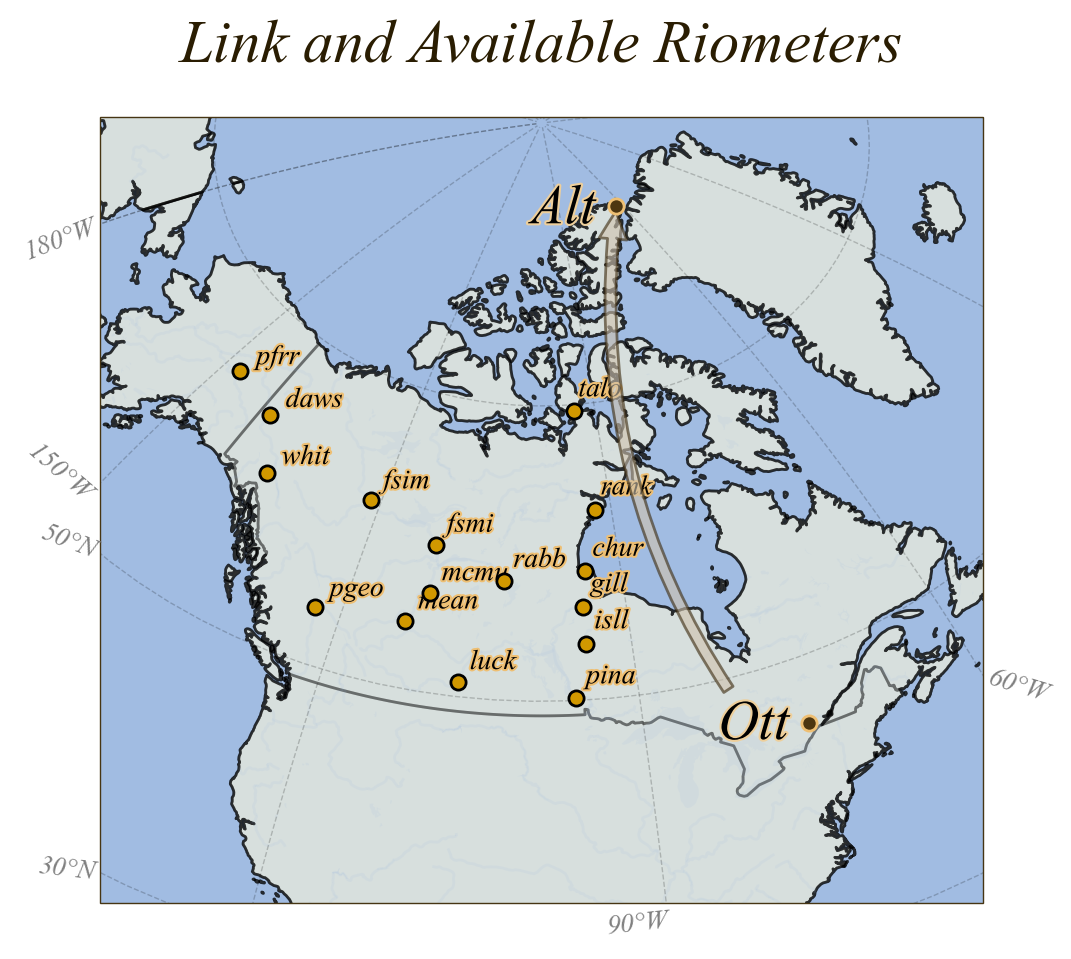

In [223]:
central_riometer = riometers['Lucky Lake, SK']

geo_map = OrthoMap(central_riometer, radius=10, r_padding=5, title="Link and Available Riometers", lat_shift=12, lon_shift=8)
geo_map.show_map()
geo_map.show_riometers([rio for rio in riometer_list if  rio.tag.islower()], "#D19800")
geo_map.show_path("Ott", ( - 75.69, 45.42 ), "Alt", ( - 62.35, 82.50))
